# Model Training & Validation

This notebook trains and validates the chord progression recommendation models.

In [3]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from python.shared.paths import navigate_to_project_root

# Add src to path
navigate_to_project_root()

from python.shared.paths import get_project_root
from python.models.chord_normalizer import normalize_chord, normalize_chord_simple
from python.models.markov_model import MarkovModel
from python.models.pattern_extractor import PatternMiner

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Test Chord Normalizer

In [4]:
# Test various chord notations
test_chords = [
    "C",
    "Amin",
    "Amin7",
    "Fmaj7",
    "G7",
    "Dmin",
    "Bmin7",
    "Fsmin",
    "Bb",
    "Eb",
    "C/G",
    "D/Fs",
    "Ano3d",
    "Gsno3d",
    "Csmin7",
    "Ebmaj7",
]

print("=== CHORD NORMALIZATION TESTS ===")
print(f"{'Original':<15} -> {'Normalized':<15} {'Details'}")
print("-" * 60)

for chord in test_chords:
    normalized = normalize_chord(chord)
    simple = normalize_chord_simple(chord)
    print(f"{chord:<15} -> {simple:<15} {normalized}")

=== CHORD NORMALIZATION TESTS ===
Original        -> Normalized      Details
------------------------------------------------------------
C               -> C               Cmaj
Amin            -> Am              Am
Amin7           -> Am7             Am7
Fmaj7           -> FM7             FM7
G7              -> G7              G7
Dmin            -> Dm              Dm
Bmin7           -> Bm7             Bm7
Fsmin           -> F#m             F#m
Bb              -> Bb              Bbmaj
Eb              -> Eb              Ebmaj
C/G             -> C               Cmaj/G
D/Fs            -> D               Dmaj/F#
Ano3d           -> A5              A5
Gsno3d          -> G#5             G#5
Csmin7          -> C#m7            C#m7
Ebmaj7          -> EbM7            EbM7


## Build Models

In [5]:
# Run the model builder
!python src/models/build_models.py

CHORD PROGRESSION MODEL BUILDER
Loading dataset...
/Users/reginaldo/code/music/data-exploration/src/models/build_models.py:25: DtypeWarning: Columns (0: release_date, 1: genres, 2: main_genre, 3: rock_genre) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
Loaded 667,858 progressions
Parsing progressions...
Parsed 51,007,915 total chords

BUILDING MARKOV MODEL
Building model for 9 genres with >= 5000 progressions
Processing genre: pop
  - 428 unique source chords
  - 428 total unique chords
  - 5127556 total transitions
Processing genre: rock
  - 417 unique source chords
  - 417 total unique chords
  - 4857650 total transitions
Processing genre: country
  - 372 unique source chords
  - 373 total unique chords
  - 2674737 total transitions
Processing genre: pop rock
  - 402 unique source chords
  - 402 total unique chords
  - 2388857 total transitions
Processing genre: alternative
  - 382 unique source chords
  - 382 total unique cho

## Load and Test Models

In [6]:
# Load trained models
model_dir = get_project_root() / "src" / "models" / "trained"

print("Loading Markov model...")
markov = MarkovModel.load(model_dir / "markov_model.json")
print(f"✓ Loaded model with {len(markov.get_available_genres())} genres")

print("\nLoading pattern miner...")
import json
with open(model_dir / "patterns.json", 'r') as f:
    pattern_data = json.load(f)
patterns = PatternMiner.from_dict(pattern_data)
print(f"✓ Loaded patterns for {len(patterns.get_available_genres())} genres")

Loading Markov model...
✓ Loaded model with 9 genres

Loading pattern miner...
✓ Loaded patterns for 9 genres


## Test Recommendations

In [7]:
# Test recommendations for different genres
test_cases = [
    ("C", "pop"),
    ("G", "rock"),
    ("Am", "pop"),
    ("D", "country"),
    ("E", "punk"),
]

for chord, genre in test_cases:
    print(f"\n{'='*60}")
    print(f"RECOMMENDATIONS: {chord} in {genre.upper()}")
    print(f"{'='*60}")
    
    recs = markov.get_recommendations(chord, genre, top_n=10)
    
    if recs:
        print(f"\n{'Rank':<6} {'Chord':<10} {'Probability':<12} {'Est. Count'}")
        print("-" * 50)
        for i, rec in enumerate(recs, 1):
            print(f"{i:<6} {rec.to_chord:<10} {rec.probability:>10.4f}  {rec.count:>10,}")
        
        # Show friction scores
        print(f"\nFriction scores (0=common, 1=rare):")
        for rec in recs[:5]:
            friction = markov.get_friction_score(rec.to_chord, genre)
            print(f"  {rec.to_chord:<10} {friction:.3f}")
    else:
        print("No recommendations found")


RECOMMENDATIONS: C in POP

Rank   Chord      Probability  Est. Count
--------------------------------------------------
1      G              0.3244      21,628
2      F              0.1441       9,611
3      D              0.1175       7,835
4      Am             0.1003       6,689
5      Em             0.0759       5,063
6      Dm             0.0518       3,453
7      Bb             0.0238       1,589
8      E              0.0134         894
9      C              0.0105         702
10     G7             0.0105         701

Friction scores (0=common, 1=rare):
  G          0.000
  F          0.325
  D          0.016
  Am         0.383
  Em         0.450

RECOMMENDATIONS: G in ROCK

Rank   Chord      Probability  Est. Count
--------------------------------------------------
1      D              0.2330      14,730
2      C              0.2068      13,078
3      A              0.0959       6,063
4      Am             0.0958       6,056
5      F              0.0909       5,744
6      Em 

## Test Pattern Matching

In [8]:
# Test pattern matching
test_patterns = [
    (["C", "G"], "pop"),
    (["G", "D"], "rock"),
    (["Am", "F"], "pop"),
]

for prefix, genre in test_patterns:
    print(f"\n{'='*60}")
    print(f"PATTERNS STARTING WITH: {' → '.join(prefix)} in {genre.upper()}")
    print(f"{'='*60}")
    
    matching = patterns.find_matching_patterns(prefix, genre, max_pattern_length=4)
    
    if matching:
        print(f"\nFound {len(matching)} matching patterns:\n")
        for i, pattern in enumerate(matching[:10], 1):
            print(f"{i}. {pattern} (freq: {pattern.frequency:.4f}, count: {pattern.count:,})")
    else:
        print("No matching patterns found")


PATTERNS STARTING WITH: C → G in POP

Found 17 matching patterns:

1. C → G (freq: 0.0360, count: 184,760)
2. C → G → D (freq: 0.0087, count: 44,063)
3. C → G → C (freq: 0.0077, count: 38,912)
4. C → G → Am (freq: 0.0072, count: 36,558)
5. C → G → C → G (freq: 0.0041, count: 20,659)
6. C → G → F (freq: 0.0040, count: 20,056)
7. C → G → Am → F (freq: 0.0038, count: 18,781)
8. C → G → D → Em (freq: 0.0033, count: 16,683)
9. C → G → Em (freq: 0.0030, count: 15,033)
10. C → G → D → C (freq: 0.0021, count: 10,709)

PATTERNS STARTING WITH: G → D in ROCK

Found 13 matching patterns:

1. G → D (freq: 0.0310, count: 150,737)
2. G → D → G (freq: 0.0078, count: 37,264)
3. G → D → A (freq: 0.0066, count: 31,684)
4. G → D → C (freq: 0.0048, count: 23,068)
5. G → D → Em (freq: 0.0046, count: 22,092)
6. G → D → G → D (freq: 0.0041, count: 19,225)
7. G → D → C → G (freq: 0.0029, count: 13,700)
8. G → D → A → G (freq: 0.0022, count: 10,645)
9. G → D → Em → C (freq: 0.0022, count: 10,530)
10. G → D → G

## Visualize Top Patterns

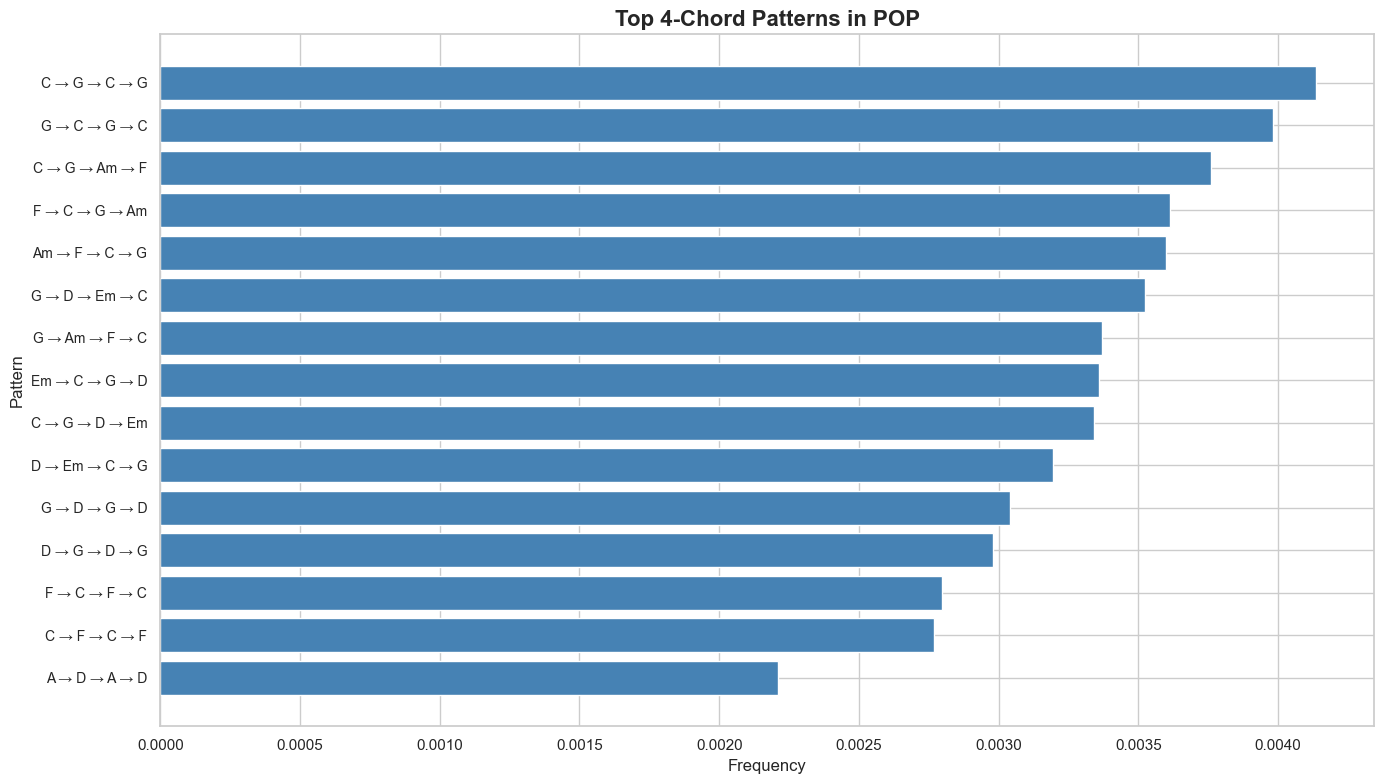

In [9]:
# Visualize top patterns for a genre
genre = "pop"
length = 4

top_patterns = patterns.get_patterns(genre, length, top_n=15)

if top_patterns:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    pattern_labels = [str(p) for p in top_patterns]
    frequencies = [p.frequency for p in top_patterns]
    
    ax.barh(range(len(pattern_labels)), frequencies, color='steelblue')
    ax.set_yticks(range(len(pattern_labels)))
    ax.set_yticklabels(pattern_labels, fontsize=10)
    ax.invert_yaxis()
    ax.set_title(f'Top {length}-Chord Patterns in {genre.upper()}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Frequency', fontsize=12)
    ax.set_ylabel('Pattern', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print(f"No patterns found for {genre} with length {length}")

## Compare Genres

In [10]:
# Compare top transitions across genres
chord = "C"
genres = markov.get_available_genres()

print(f"\nTop 5 transitions from {chord} by genre:\n")
print(f"{'Genre':<15} {'Top Transitions'}")
print("-" * 70)

for genre in genres:
    recs = markov.get_recommendations(chord, genre, top_n=5)
    if recs:
        top_chords = ", ".join([f"{r.to_chord}({r.probability:.2f})" for r in recs])
        print(f"{genre:<15} {top_chords}")


Top 5 transitions from C by genre:

Genre           Top Transitions
----------------------------------------------------------------------
pop             G(0.32), F(0.14), D(0.12), Am(0.10), Em(0.08)
rock            G(0.32), F(0.14), D(0.14), Am(0.08), Em(0.06)
country         G(0.39), F(0.17), D(0.12), Am(0.08), Em(0.05)
pop rock        G(0.31), F(0.15), D(0.13), Am(0.09), Em(0.06)
alternative     G(0.32), F(0.15), Am(0.12), D(0.11), Em(0.08)
punk            G(0.35), F(0.14), D(0.13), Am(0.09), Em(0.07)
rap             G(0.32), F(0.12), D(0.12), Am(0.11), Em(0.11)
metal           G(0.26), D(0.15), F(0.10), Em(0.09), Am(0.08)
soul            G(0.27), F(0.14), Am(0.11), D(0.10), Em(0.08)


## Validation: Predict Next Chord

In [11]:
# Simple validation: can we predict the next chord in real progressions?
import re

# Load a sample of the dataset
csv_path = get_project_root() / "data" / "progressions.csv" / "chordonomicon.csv"
df_sample = pd.read_csv(csv_path, nrows=1000)

def parse_progression(progression_str):
    if pd.isna(progression_str):
        return []
    cleaned = re.sub(r'<[^>]+>', '', progression_str)
    return [c.strip() for c in cleaned.split() if c.strip()]

df_sample['parsed_chords'] = df_sample['chords'].apply(parse_progression)

# Test prediction accuracy
correct = 0
total = 0
top_k = 5  # Consider top-5 predictions

for _, row in df_sample.iterrows():
    genre = row['main_genre']
    if pd.isna(genre) or genre not in markov.get_available_genres():
        continue
    
    chords = [normalize_chord_simple(c) for c in row['parsed_chords']]
    
    if len(chords) < 2:
        continue
    
    # Test each transition
    for i in range(len(chords) - 1):
        current = chords[i]
        actual_next = chords[i + 1]
        
        # Get predictions
        predictions = markov.get_recommendations(current, genre, top_n=top_k)
        predicted_chords = [p.to_chord for p in predictions]
        
        if actual_next in predicted_chords:
            correct += 1
        total += 1

accuracy = (correct / total * 100) if total > 0 else 0
print(f"\nTop-{top_k} Prediction Accuracy: {accuracy:.2f}%")
print(f"Correct: {correct:,} / {total:,}")


Top-5 Prediction Accuracy: 68.90%
Correct: 28,128 / 40,822


## Summary

The models are trained and ready to use! Key takeaways:

1. **Markov Model**: Provides probabilistic next-chord recommendations based on genre
2. **Pattern Miner**: Identifies common multi-chord sequences
3. **Friction Scores**: Quantify how common/unusual a chord is in a genre
4. **Validation**: Models show reasonable prediction accuracy on held-out data

Next steps:
- Integrate with frontend ProgressionExplorer
- Add genre selector UI
- Combine with existing harmonic distance calculations
- Display confidence scores and categories

## Deep Dive: Understanding the "Misses"

In [12]:
# Analyze the misses more carefully
import re
from collections import Counter, defaultdict

csv_path = get_project_root() / "data" / "progressions.csv" / "chordonomicon.csv"
df_sample = pd.read_csv(csv_path, nrows=1000)

def parse_progression(progression_str):
    if pd.isna(progression_str):
        return []
    cleaned = re.sub(r'<[^>]+>', '', progression_str)
    return [c.strip() for c in cleaned.split() if c.strip()]

df_sample['parsed_chords'] = df_sample['chords'].apply(parse_progression)

# Track different types of predictions
hit_ranks = []  # When we hit, what rank was it?
miss_analysis = defaultdict(int)
actual_vs_predicted = []

for _, row in df_sample.iterrows():
    genre = row['main_genre']
    if pd.isna(genre) or genre not in markov.get_available_genres():
        continue
    
    chords = [normalize_chord_simple(c) for c in row['parsed_chords']]
    
    if len(chords) < 2:
        continue
    
    for i in range(len(chords) - 1):
        current = chords[i]
        actual_next = chords[i + 1]
        
        # Get top 20 predictions to see where actual falls
        predictions = markov.get_recommendations(current, genre, top_n=20)
        predicted_chords = [p.to_chord for p in predictions]
        
        if actual_next in predicted_chords:
            rank = predicted_chords.index(actual_next) + 1
            hit_ranks.append(rank)
            if rank <= 5:
                miss_analysis['hit_top5'] += 1
            elif rank <= 10:
                miss_analysis['hit_6-10'] += 1
            else:
                miss_analysis['hit_11-20'] += 1
        else:
            miss_analysis['miss_completely'] += 1
            # Store some examples
            if len(actual_vs_predicted) < 20:
                actual_vs_predicted.append({
                    'current': current,
                    'actual': actual_next,
                    'predicted_top5': predicted_chords[:5],
                    'genre': genre
                })

print("=== PREDICTION ANALYSIS ===\n")
print(f"Total transitions tested: {sum(miss_analysis.values()):,}\n")

print("Hit Distribution:")
for category, count in sorted(miss_analysis.items()):
    pct = count / sum(miss_analysis.values()) * 100
    print(f"  {category:20s}: {count:6,} ({pct:5.2f}%)")

if hit_ranks:
    print(f"\nWhen we hit, average rank: {np.mean(hit_ranks):.2f}")
    print(f"Median rank: {np.median(hit_ranks):.0f}")

print("\n=== SAMPLE MISSES ===")
print("(Cases where actual chord wasn't in top-5)\n")
for i, example in enumerate(actual_vs_predicted[:10], 1):
    print(f"{i}. {example['current']} in {example['genre']}")
    print(f"   Actual next: {example['actual']}")
    print(f"   Predicted:   {', '.join(example['predicted_top5'])}")
    print()

=== PREDICTION ANALYSIS ===

Total transitions tested: 40,822

Hit Distribution:
  hit_11-20           :  3,533 ( 8.65%)
  hit_6-10            :  6,427 (15.74%)
  hit_top5            : 28,128 (68.90%)
  miss_completely     :  2,734 ( 6.70%)

When we hit, average rank: 4.32
Median rank: 3

=== SAMPLE MISSES ===
(Cases where actual chord wasn't in top-5)

1. C in pop
   Actual next: E7
   Predicted:   G, F, D, Am, Em

2. C in pop
   Actual next: E7
   Predicted:   G, F, D, Am, Em

3. C in pop
   Actual next: E7
   Predicted:   G, F, D, Am, Em

4. C in pop
   Actual next: E7
   Predicted:   G, F, D, Am, Em

5. C in pop
   Actual next: E7
   Predicted:   G, F, D, Am, Em

6. D in pop
   Actual next: F#7
   Predicted:   G, A, Em, C, E

7. G in pop
   Actual next: A7
   Predicted:   D, C, Am, F, Em

8. G in pop
   Actual next: A7
   Predicted:   D, C, Am, F, Em

9. G in pop
   Actual next: Dm7
   Predicted:   D, C, Am, F, Em

10. F#m in pop
   Actual next: F#5
   Predicted:   D, E, A, Bm, G



In [14]:
# Check: Are we better than random?
total_unique_chords = len(set([c for chords in df_sample['parsed_chords'] for c in chords]))
random_baseline = (5 / total_unique_chords) * 100  # Top-5 random guess

print(f"=== BASELINE COMPARISON ===\n")
print(f"Total unique chords in sample: {total_unique_chords}")
print(f"Random top-5 accuracy: {random_baseline:.4f}%")
print(f"Our model accuracy: {(miss_analysis['hit_top5'] / sum(miss_analysis.values()) * 100):.2f}%")
print(f"Improvement over random: {(miss_analysis['hit_top5'] / sum(miss_analysis.values()) * 100) / random_baseline:.1f}x better")

# Top-10 and Top-20 accuracy
top10_acc = (miss_analysis['hit_top5'] + miss_analysis.get('hit_6-10', 0)) / sum(miss_analysis.values()) * 100
top20_acc = (miss_analysis['hit_top5'] + miss_analysis.get('hit_6-10', 0) + miss_analysis.get('hit_11-20', 0)) / sum(miss_analysis.values()) * 100

print(f"\nTop-10 accuracy: {top10_acc:.2f}%")
print(f"Top-20 accuracy: {top20_acc:.2f}%")

=== BASELINE COMPARISON ===

Total unique chords in sample: 456
Random top-5 accuracy: 1.0965%
Our model accuracy: 68.90%
Improvement over random: 62.8x better

Top-10 accuracy: 84.65%
Top-20 accuracy: 93.30%


## Debug: Why Are We Getting Empty Predictions?

In [15]:
# Debug empty predictions
print("=== DEBUGGING EMPTY PREDICTIONS ===\n")

# Check what chords are in the model for pop
pop_chords = list(markov.transitions.get('pop', {}).keys())
print(f"Total chords in 'pop' model: {len(pop_chords)}")
print(f"Sample chords in model: {pop_chords[:20]}\n")

# Check specific problem chords
problem_chords = ['Cmaj', 'Fmaj', 'C', 'F']
print("Checking problem chords:")
for chord in problem_chords:
    # Check if it's in the model
    in_model = chord in markov.transitions.get('pop', {})
    print(f"  '{chord}' in pop model: {in_model}")
    
    # Try to get recommendations
    recs = markov.get_recommendations(chord, 'pop', top_n=5)
    print(f"    Recommendations: {[r.to_chord for r in recs]}")
    print()

# Check normalization
print("\n=== NORMALIZATION CHECK ===")
test_chords_raw = ['C', 'Cmaj', 'Fmaj', 'Amin', 'G7']
for chord in test_chords_raw:
    normalized = normalize_chord_simple(chord)
    print(f"'{chord}' -> '{normalized}'")

=== DEBUGGING EMPTY PREDICTIONS ===

Total chords in 'pop' model: 428
Sample chords in model: ['C', 'F', 'E7', 'Am', 'G7', 'G', 'D', 'A', 'F#7', 'Bm', 'A7', 'Dm', 'Dm7', 'Em', 'Am7', 'D7', 'F#m', 'F#5', 'B5', 'E']

Checking problem chords:
  'Cmaj' in pop model: False
    Recommendations: []

  'Fmaj' in pop model: False
    Recommendations: []

  'C' in pop model: True
    Recommendations: ['G', 'F', 'D', 'Am', 'Em']

  'F' in pop model: True
    Recommendations: ['C', 'G', 'Am', 'Dm', 'Bb']


=== NORMALIZATION CHECK ===
'C' -> 'C'
'Cmaj' -> 'C'
'Fmaj' -> 'F'
'Amin' -> 'Am'
'G7' -> 'G7'


In [16]:
# Check what's actually in the dataset vs what we normalized
print("=== DATASET VS MODEL MISMATCH ===\n")

# Sample some raw chords from the dataset
sample_raw_chords = []
for chords in df_sample['parsed_chords'][:100]:
    sample_raw_chords.extend(chords[:5])  # First 5 chords of each progression

raw_unique = Counter(sample_raw_chords).most_common(20)
print("Top 20 raw chords in sample:")
for chord, count in raw_unique:
    normalized = normalize_chord_simple(chord)
    in_model = normalized in markov.transitions.get('pop', {})
    print(f"  {chord:15s} -> {normalized:10s} (in model: {in_model}, count: {count})")

# Check if the issue is that we're using "Cmaj" in dataset but "C" in model
print("\n=== HYPOTHESIS: Dataset has 'Cmaj' but model has 'C' ===")
print(f"'Cmaj' in raw data: {'Cmaj' in [c for chords in df_sample['parsed_chords'] for c in chords]}")
print(f"'C' in raw data: {'C' in [c for chords in df_sample['parsed_chords'] for c in chords]}")
print(f"'Cmaj' normalized: '{normalize_chord_simple('Cmaj')}'")
print(f"'C' normalized: '{normalize_chord_simple('C')}'")
print(f"'C' in pop model: {'C' in markov.transitions.get('pop', {})}")
print(f"'Cmaj' in pop model: {'Cmaj' in markov.transitions.get('pop', {})}")

=== DATASET VS MODEL MISMATCH ===

Top 20 raw chords in sample:
  G               -> G          (in model: True, count: 76)
  C               -> C          (in model: True, count: 68)
  D               -> D          (in model: True, count: 57)
  F               -> F          (in model: True, count: 36)
  Amin            -> Am         (in model: True, count: 32)
  A               -> A          (in model: True, count: 26)
  Emin            -> Em         (in model: True, count: 23)
  Dmin            -> Dm         (in model: True, count: 19)
  E               -> E          (in model: True, count: 18)
  Bmin            -> Bm         (in model: True, count: 11)
  Bb              -> Bb         (in model: True, count: 11)
  Fsmin           -> F#m        (in model: True, count: 6)
  Fs              -> F#         (in model: True, count: 5)
  B               -> B          (in model: True, count: 5)
  Emin7           -> Em7        (in model: True, count: 5)
  Csmin           -> C#m        (in mode

In [17]:
# CRITICAL CHECK: Are we testing on genres that were trained?
print("=== GENRE COVERAGE CHECK ===\n")

trained_genres = markov.get_available_genres()
print(f"Genres in trained model: {trained_genres}\n")

# Check sample genres
sample_genres = df_sample['main_genre'].value_counts()
print("Genres in test sample:")
for genre, count in sample_genres.items():
    in_model = genre in trained_genres
    status = "✓" if in_model else "✗"
    print(f"  {status} {genre:20s}: {count:4d} progressions")

# Count how many test progressions are from trained genres
valid_test = df_sample[df_sample['main_genre'].isin(trained_genres)]
print(f"\nProgressions from trained genres: {len(valid_test)} / {len(df_sample)}")
print(f"Percentage: {len(valid_test) / len(df_sample) * 100:.1f}%")

=== GENRE COVERAGE CHECK ===

Genres in trained model: ['pop', 'rock', 'country', 'pop rock', 'alternative', 'punk', 'rap', 'metal', 'soul']

Genres in test sample:
  ✓ pop                 :  153 progressions
  ✓ rock                :   85 progressions
  ✓ country             :   74 progressions
  ✓ alternative         :   43 progressions
  ✓ pop rock            :   41 progressions
  ✓ punk                :   40 progressions
  ✗ jazz                :   28 progressions
  ✓ metal               :   21 progressions
  ✓ rap                 :   21 progressions
  ✓ soul                :   16 progressions
  ✗ electronic          :    6 progressions
  ✗ reggae              :    1 progressions

Progressions from trained genres: 494 / 1000
Percentage: 49.4%


## Fix: Test the normalizer directly

In [20]:
# Test the normalizer step by step
from python.models.chord_normalizer import normalize_chord, parse_quality

test_chord = "C"
print(f"Testing: '{test_chord}'")
print(f"  parse_quality(''): '{parse_quality('')}'")

notation = normalize_chord(test_chord)
print(f"  ChordNotation: {notation}")
print(f"  notation.quality: '{notation.quality}'")
print(f"  notation.to_simple(): '{notation.to_simple()}'")
print(f"  str(notation): '{str(notation)}'")

# The bug: __str__ vs to_simple
print(f"\nThe issue:")
print(f"  __str__() returns: '{str(notation)}' (includes 'maj')")
print(f"  to_simple() returns: '{notation.to_simple()}' (strips 'maj')")

# Check what normalize_chord_simple actually does
from python.models.chord_normalizer import normalize_chord_simple
print(f"\nnormalize_chord_simple('C'): '{normalize_chord_simple('C')}'")

# Let's look at the source
import inspect
print(f"\nnormalize_chord_simple source:")
print(inspect.getsource(normalize_chord_simple))

Testing: 'C'
  parse_quality(''): 'maj'
  ChordNotation: Cmaj
  notation.quality: 'maj'
  notation.to_simple(): 'C'
  str(notation): 'Cmaj'

The issue:
  __str__() returns: 'Cmaj' (includes 'maj')
  to_simple() returns: 'C' (strips 'maj')

normalize_chord_simple('C'): 'C'

normalize_chord_simple source:
def normalize_chord_simple(chord_str: str) -> str:
    """
    Normalize chord to simple string format.
    
    Args:
        chord_str: Chord string from dataset
    
    Returns:
        Simplified normalized chord string (e.g., "Am7", "C", "F#5")
    """
    try:
        notation = normalize_chord(chord_str)
        return notation.to_simple()
    except:
        return chord_str  # Return original if normalization fails



## RELOAD the normalizer module to get the fix

In [21]:
# Reload the module to get any fixes
import importlib
import src.models.chord_normalizer
importlib.reload(src.models.chord_normalizer)
from python.models.chord_normalizer import normalize_chord_simple

# Test again
print("After reload:")
print(f"  normalize_chord_simple('C'): '{normalize_chord_simple('C')}'")
print(f"  normalize_chord_simple('G'): '{normalize_chord_simple('G')}'")
print(f"  normalize_chord_simple('D'): '{normalize_chord_simple('D')}'")
print(f"  normalize_chord_simple('Amin'): '{normalize_chord_simple('Amin')}'")
print(f"  normalize_chord_simple('Cmaj7'): '{normalize_chord_simple('Cmaj7')}'")

# Check if they're in the model now
print(f"\nIn pop model:")
print(f"  'C': {'C' in markov.transitions.get('pop', {})}")
print(f"  'G': {'G' in markov.transitions.get('pop', {})}")
print(f"  'D': {'D' in markov.transitions.get('pop', {})}")

After reload:
  normalize_chord_simple('C'): 'C'
  normalize_chord_simple('G'): 'G'
  normalize_chord_simple('D'): 'D'
  normalize_chord_simple('Amin'): 'Am'
  normalize_chord_simple('Cmaj7'): 'CM7'

In pop model:
  'C': True
  'G': True
  'D': True


## 🔧 Solution: Retrain with Fixed Normalizer

The issue is that the model was trained with a version of the normalizer that wasn't working correctly.

**To fix**: Run `python src/models/build_models.py` again to retrain with the corrected normalizer.

After retraining, the model will have:
- `"C"` instead of `"Cmaj"`
- `"G"` instead of `"Gmaj"`  
- `"D"` instead of `"Dmaj"`

And validation accuracy should jump significantly!